# Christmas Card Embeddings

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
from tqdm import tqdm

torch.manual_seed(1)

In [8]:
with open('christmas_lyrics.txt', 'r') as file:
    lyrics_1 = file.read().split(' ')

print(len(lyrics_1))

with open('christmas_lyrics_2.txt', 'r') as file:
    lyrics_2 = file.read().split(' ')

print(len(lyrics_2))

120779
3603


In [9]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(2 * context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, input):
        # reshape tensor to be 1D tensor instead of 2D, metrix like tensor
        embeds = self.embeddings(input).view((1, -1))
        out = self.linear1(embeds)
        out = F.relu(out)
        out = self.linear2(out)
        log_probs = F.softmax(out, dim=1)
        return log_probs

In [10]:
# Remove all punctuation and convert all words to lower case
text = [re.sub(r'[^\w\s]', '', word.lower()) for word in lyrics_1]
text = list(filter(lambda x: x != '', text)) # Remove empty string from puctuation removal

vocabulary = set(text)
vocab_size = len(vocabulary)

print(f'Unique Words: {vocab_size}')

Unique Words: 11992


In [11]:
CONTEXT_SIZE = 2   # Number of terms to look back/ahead for each word
EMBEDDING_DIM = 10 # Size of each embedding vector

word_to_ix = {word: i for i, word in enumerate(vocabulary)}

# Create contexts for each target word in the text
context_targets = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    # Context is CONTEXT_SIZE words before and after word i, not including word i
    context = text[i-CONTEXT_SIZE:i] + text[i+1:i+CONTEXT_SIZE+1]
    context_targets.append((context, text[i]))

# Converts the words for a context into their ix form as a tensor
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

print(len(context_targets))

# Example of converting context vector into a context id tensor
print(make_context_vector(context_targets[0][0], word_to_ix))

112170
tensor([7887, 3765, 3564, 7644])


In [17]:
LEARNING_RATE = 0.001
EPOCHS = 5

criterion = nn.NLLLoss()
model = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
optimiser = optim.SGD(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    for context, target in tqdm(context_targets):
        context_idx = make_context_vector(context, word_to_ix)

        model.zero_grad()

        log_probs = model(context_idx)

        loss = criterion(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        loss.backward()
        optimiser.step()

        total_loss += loss.item()

    losses.append(total_loss)

print(losses)

100%|██████████| 112170/112170 [08:02<00:00, 232.67it/s]

[-9.378640201392045, -9.383296534557303, -9.387973505601622, -9.392671282545052, -9.397390279744286]


## Load an existing version of the model

In [18]:
import json

with open('word_to_ix.txt', 'w') as file:
    json_string = json.dumps(word_to_ix)
    file.write(json_string)

torch.save(model, 'christmas_embeddings.pt')

In [16]:
import json

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(2 * context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, input):
        # reshape tensor to be 1D tensor instead of 2D, metrix like tensor
        embeds = self.embeddings(input).view((1, -1))
        out = self.linear1(embeds)
        out = F.relu(out)
        out = self.linear2(out)
        log_probs = F.softmax(out, dim=1)
        return log_probs

# Load the model and the word_to_ix dictionary
model = torch.load('christmas_embeddings.pt')
with open('word_to_ix.txt', 'r') as json_file:
    word_to_ix = json.load(json_file)

## Create the graph

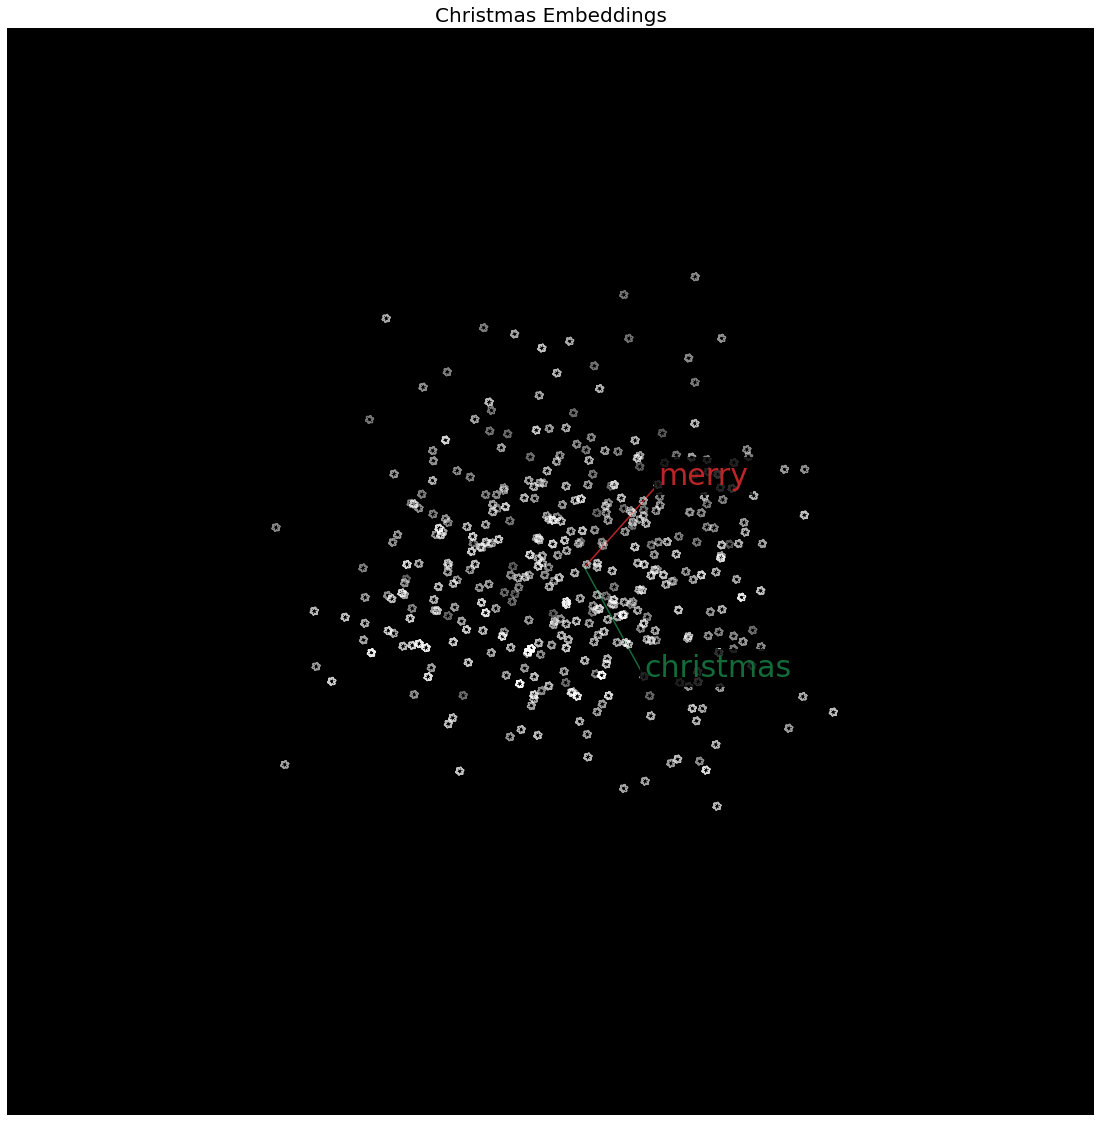

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

snowflake_path, attributes = svg2paths('snowflake.svg')
snowflake_marker = parse_path(attributes[0]['d'])
snowflake_marker.vertices -= snowflake_marker.vertices.mean(axis=0)
snowflake_marker = snowflake_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
snowflake_marker = snowflake_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))


pca = PCA(n_components=3)
pca_results = pca.fit_transform(model.embeddings.weight.detach())

fig = plt.figure( figsize=(20, 20))
ax = plt.axes(projection='3d')
#ax = plt.axes()
ax.axis('off')
ax.set_facecolor('black')


num = len(word_to_ix)
np.random.seed(0)
random_idxs = np.random.randint(low=0, high=num, size=400)
merry_idx = word_to_ix['merry']
christmas_idx = word_to_ix['christmas']

all_idxs = np.append(random_idxs, [merry_idx, christmas_idx])
x_data = pca_results[all_idxs, 0]
y_data = pca_results[all_idxs, 1]
z_data = pca_results[all_idxs, 2]

ax.set_title('Christmas Embeddings', fontsize=20)
#ax.scatter(x_data, y_data, c='white', s=5)
ax.invert_zaxis()
ax.scatter3D(x_data, y_data, z_data, s=70, c='white', marker=snowflake_marker)

x_1 = [0, pca_results[merry_idx, 0]]
y_1 = [0, pca_results[merry_idx, 1]]
z_1 = [0, pca_results[merry_idx, 2]]

x_2 = [0, pca_results[christmas_idx, 0]]
y_2 = [0, pca_results[christmas_idx, 1]]
z_2 = [0, pca_results[christmas_idx, 2]]

ax.plot(x_1, y_1, z_1, color='#bb2528')
ax.plot(x_2, y_2, z_2, color='#146b3a')

#ax.plot(x_1, y_1, color='#bb2528')
#ax.plot(x_2, y_2, color='#146b3a')

t_1 = ax.text(pca_results[merry_idx, 0], pca_results[merry_idx, 1], pca_results[merry_idx, 2], 'merry', fontsize=30, c='#bb2528')
t_1.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='black'))

t_2 = ax.text(pca_results[christmas_idx, 0], pca_results[christmas_idx, 1], pca_results[christmas_idx, 2], 'christmas', fontsize=30, c='#146b3a')
t_2.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='black'))

#ax.text(pca_results[merry_idx, 0], pca_results[merry_idx, 1], 'merry', fontsize=30, c='#bb2528')
#ax.text(pca_results[christmas_idx, 0], pca_results[christmas_idx, 1], 'christmas', fontsize=30, c='#146b3a')